## Lecture 4: Big Data: Challenges and Solutions

These notes at times closely follow [Ryan Abernathey's lecture notes on Dask and Big Data](https://rabernat.github.io/research_computing/dask-for-parallel-computing-and-big-data.html).

### MIT Practical Computing Tutorials for Earth Scientists
<hr>

![Snapshot of surface current speed in the 1/48th degree resolution MITgcm LLC4320 simulation](http://mitgcm.org/wp-content/uploads/2019/04/bluemarble_surface_currents_llc4320_slr.jpg "MITgcm LLC4320 surface current speed")
[Source: [MITgcm blog](http://mitgcm.org/wp-content/uploads/2019/04/bluemarble_surface_currents_llc4320_slr.jpg)]

### What is "big data?"

"Big data" is when data sets are so large and/or complicated that conventional data processing and analysis software are no longer adequate for a desired task.

##### The point of this tutorial is to review intuitive, efficient, and scalable state-of-the-art tools that enable analysis of big data.

Practically, it is useful to categorize data into different sizes:

1. **Small data (2-1 TB): fits in a laptop or HPC cluster's RAM**\
Most modern laptops have between 2 and 16 GB of RAM while high-end High Performance Computing (HPC) nodes can have up to 1 TB of RAM. Data sets that can be loaded into RAM all at once are straight-forward to analyze and conventional tools suffice (e.g. download a local copy of the data set, read into your favorite programming environment, and analyze away).

2. **Medium data (100 GB-10 TB): fits in hard drive but not in RAM**\
Most modern laptops have at least 100 GB of storage space on the hard drive and HPC storage can be many TB or even PB. In any case, since the data sets do not fit in RAM, both the reading and analysis of data need to be split into chunks to do fit in RAM. The conventional work-around is for the data sets to be pre-processed into chunks less than a few GB so they can each individually be read into RAM (usually the files are chunked along a time dimension or other conveniently chunk-able dimension). In cases where the analysis is embarassingly parallel (e.g. a derived value can be computed independently for each chunk and then recombined in a final step), then the analysis can remain fairly straightfoward. In other cases, ad-hoc algorithms need to be implemented just to organize loading and analyzing the data.

3. **Big data (Many TB): too large for interactive serial analysis**\
It can take days just to download or perform basic operations on data sets many TB in size. The conventional workflow in these cases is to develop, debug, and test analysis algorithms interactively on small, representative subsets of the data which fit in RAM, and then finally scaling them up to analyze the full data set non-interactively (e.g. by submitting a job to a cluster). While many tools for parallelizing numerical simulation and data analysis exist, many of these tools are not as helpful for handling inputs / output (I/O) for big data sets, which is often the limiting task.

4. **Huge data (Many PB or EB): prohibitively expensive to store / analyze**\
For data sets many PB in size (e.g. the entirety of CMIP6 output on ESGF, at 20 PB).

### Challenges in big data analysis

Let's say your collaborator in Europe has generated a 100 TB data set that they would like for you to analyze. How would you proceed and what would be the major barriers to progress? 

#### 1. Downloading big data locally
**Slow:** Typical download speeds at 100 MB/s so the best we can hope for is that it will take *12 days to download the full data set* (in practice, it will probably be slower). Pulling individual chunks of the data set in parallel would only provide a limited amount of speed-up until the server saturates its bandwidth (e.g. ESGF OPeNDAP server, which saturates at 140 MB/s).

**Redundant:** At the very least, the entire 100 TB data set now lives in two different locations and you have already payed twice the storage cost that would be necessary if you were both working on the same workstation / cluster. For big data sets used by large numbers of people, such as the CMIP outputs used by thousands of climate scientists worldwide, the cumulative size of all of the local copies of the data set may be orders of magnitude larger than the data set itself.

#### 2. Analyzing big data
**Difficult to organize:** The data set would need to be chunked into RAM-sized chunks, which would have to be organized into. For complicated experimental set ups, simply organizing files in a filesystem with standardized structure and filenames can be a difficult task (e.g. data sets with poor file-naming conventions; ad-hoc chunking of data sets; and/or large numbers of nested experiment types, as in the CMIP experimental design). Even if there, users may need to develop their own functions and data structures to organize all of the datasets when reading them into their programming environment.

**Non-interactive:** For data sets this large, even basic data analysis takes so long it is no longer interactive: one basically needs to know what to do, write to code to implement it, submit it as a non-interactive job to a compute node on an HPC, and wait several days for the result. It can be difficult to get a feel for data sets this large and any new ideas take weeks to test, all of which dramatically slows down the actual science that the data was meant to enable.

#### 3. Transparent sharing of big data and big data analysis

**Impractical to share:** Faced with a growing reproducibility crisis, science in general (and earth science in particular) is trending towards FAIR (Findable, Accessible, Interoperable, and Reusable) data practices. For instance, the [American Geophysical Union's new Data Policy](https://www.agu.org/Publish-with-AGU/Publish/Author-Resources/Policies/Data-policy) now requires data analyzed in papers they publish to be made available to anybody. In practice, these policies are hardly being enforced for the small derived data sets required to reproduce figures in a paper (which typically can easily fit in a Github repository), let alone data sets as big as 100 TB which could be prohibitively expensive to host. For big data sets which are meant to be shared by other researchers, however, an avenue for transparently sharing big data (and releated pre- and post-processing analysis code) benefits both the scientists publishing the data set (whose work is promoted and cited) and users of the data set (who don't have to jump through hoops to get the dataset directly from the authors or, even worse, replicate the analysis themselves to reproduce the entire data set from scratch).

<hr>

### Solutions for big data analysis: `dask`, `xarray`, and the cloud

#### Brief intro to `dask`

Here, we generate identical arrays in `numpy` and `dask` and showcase two key concepts of `dask`: 1) splitting arrays into chunks and 2) delaying computation.

In [1]:
import numpy as np

In [2]:
shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [3]:
print("Size of array:", ones_np.nbytes / 1e6, "MB")

Size of array: 32.0 MB


In [4]:
import dask.array as da
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [5]:
ones.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

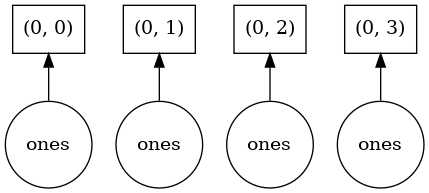

In [6]:
ones.visualize()

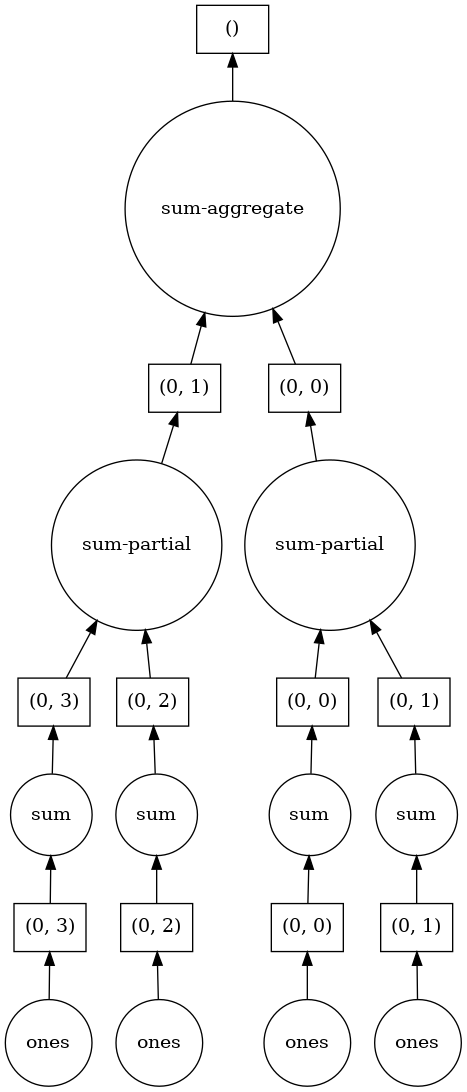

In [7]:
ones_sum = ones.sum()
ones_sum.visualize()

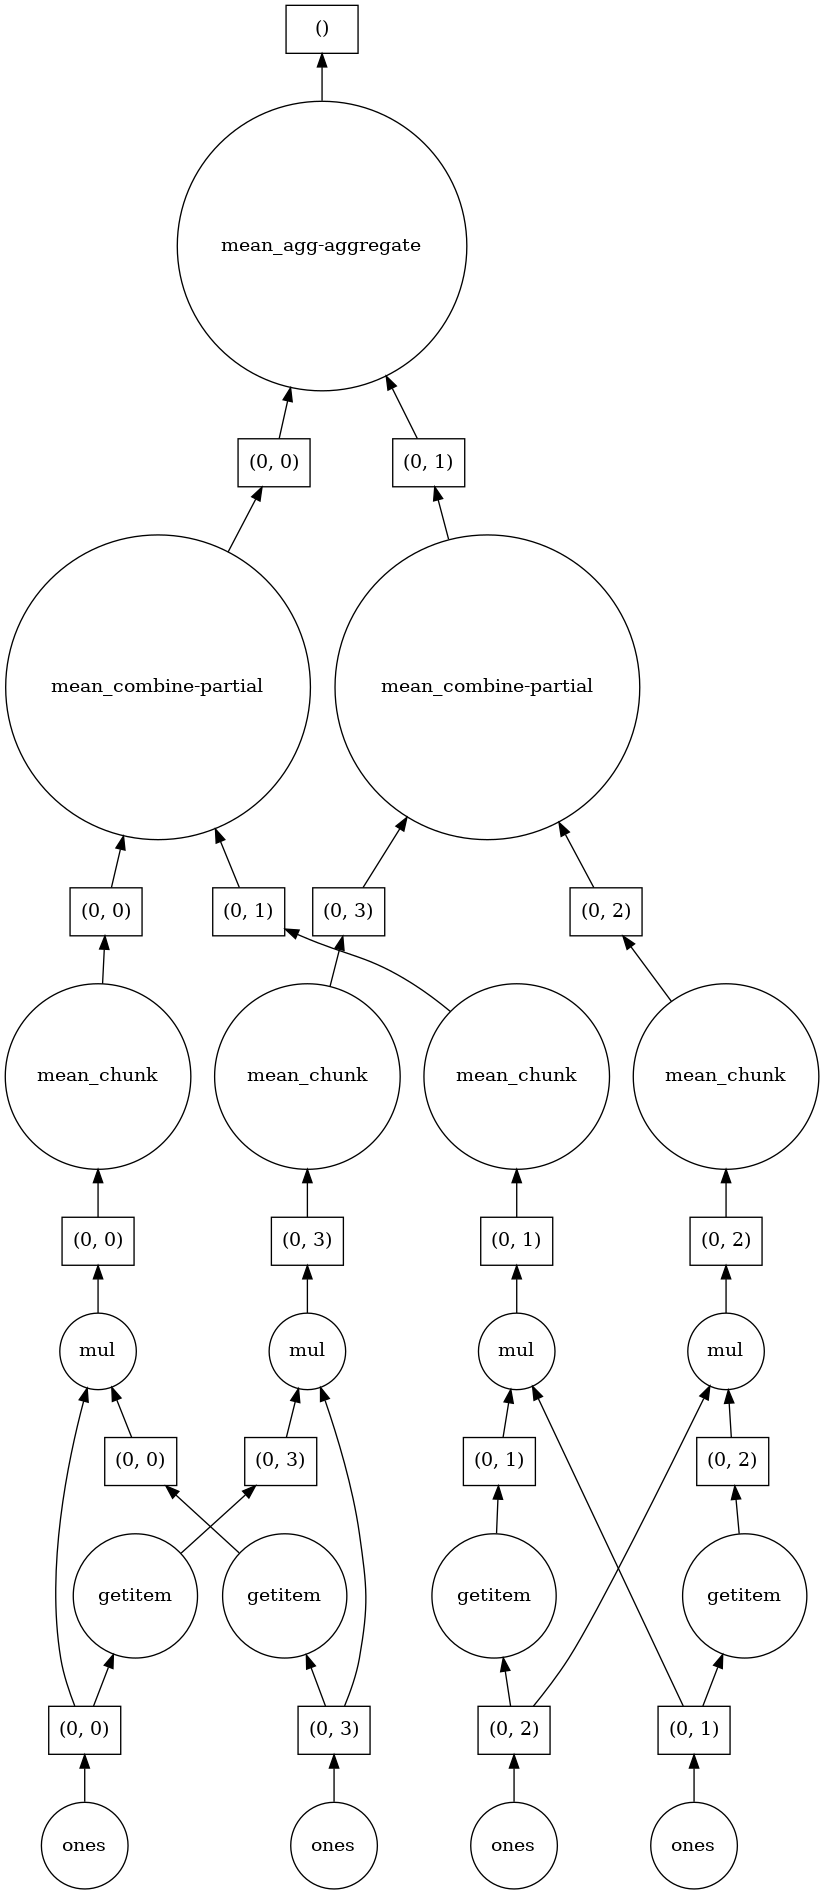

In [8]:
ones_derived = (ones * ones[::-1, ::-1]).mean()
ones_derived.visualize()

#### Brief intro to `xarray`

See [the previous Lecture04 notebook](https://github.com/PraCTES/MIT-PraCTES/blob/master/demos/Lecture04_BigData/Lecture04_wrangling_data_with_xarray.ipynb) which introduces `xarray` in the context of analyzing some small data sets.

#### Brief intro to "the cloud"

Here, we introduce the concept of the cloud via the example of the [Google Cloud Platform (GCP)](https://cloud.google.com/), which is the platform through which the present notebook is running and in which our "big data" data sets are presently stored. All of these concepts are generalizable to other cloud platforms, such as [Amazon Web Services (AWS)](https://aws.amazon.com/) and [Microsoft Azure](https://azure.microsoft.com/en-us/). All three of these industry-leading services have fairly generous free trials for you to experiment with.

<hr>

### Example: using Pangeo stack to analyze the MITgcm LLC4320 simulation in the cloud
##### `xarray` + `dask` + specialized climate analysis packages + structured cloud storage + scalable cloud computing

#### Step 1: Organizing datasets with `.yaml` metadata files and using `intake` to read them
We begin by loading in our dataset using the [`intake` package](https://intake.readthedocs.io/en/latest/), which "tak[es] the pain out of data access and distribution".

In [9]:
import intake
cat_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml'
cat = intake.Catalog(cat_url)

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


`intake` works by cataloguing the file type, location in storage, and metadata for each individual data set in a series of nested `.yaml` files. For example, the relevant excerpt from [the lowest level of `.yaml` files](https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml) describing the MITgcm LLC4320 Sea Surface Temperature dataset is shown below:

```yaml
plugins:
  source:
    - module: intake_xarray

sources:

  LLC4320_SST:
    description: MITgcm LLC4320 Ocean Simulation Sea Surface Temperature
    metadata:
      url: 'http://online.kitp.ucsb.edu/online/blayers18/menemenlis/'
      tags:
        - ocean
        - model
    driver: zarr
    args:
      urlpath: gs://pangeo-ecco-llc4320/sst
      consolidated: True
      storage_options:
        requester_pays: True

```

This `.yaml` file tells us that the catalog is meant to be read using `intake` (in particular, the part of the `intake` module that leverages `xarray`), that the file lives at `gs://pangeo-ecco-llc4320/sst` (gs stands for Google Storage) and is stored in the `zarr` format (basically, a cloud-optimized implementation of the NetCDF format), and that the person requesting access to the data pays for the transfer / download service (access is free for users of Google Cloud computing, which is what we are using right now)!

We now read the data for a few variables of interest (see the exercise below for how to learn this syntax).

In [10]:
sst = cat.ocean.LLC4320.LLC4320_SST.to_dask()
u = cat.ocean.LLC4320.LLC4320_SSU.to_dask()
v =  cat.ocean.LLC4320.LLC4320_SSV.to_dask()

/srv/conda/envs/notebook/lib/python3.7/site-packages/fsspec/implementations/local.py:32: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


In [11]:
sst['SST'].data

,Array,Chunk
Bytes,8.76 TB,74.65 MB
Shape,"(9030, 13, 4320, 4320)","(1, 1, 4320, 4320)"
Count,117391 Tasks,117390 Chunks
Type,float32,numpy.ndarray


That's a lot of data! This xarray data array holds almost 9 TB of sea surface temperature data! We can see from the table that to split this big data set into manageable peices, `dask` is working behind the scenes to chunk the dataset along the first two dimensions, resulting in manageable 75 MB chunks.

#### Step 2: Exploring the data set's metadata

Let's take a look at the `xarray.Dataset` itself to learn more about what these dimensions are.

In [12]:
sst

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables:
    SST      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In the chunking visualization above, we see that the data array has been chunked along one dimension with size 9030 (which we recognize as the "time" dimension) and a second dimension with size 13 (which we recognize as the "face" dimension).

The LLC4320 simulation breaks the world up into 13 "faces" (see below), which need to be stiched together after the fact.

![Mosaic of grid faces of the MITgcm LLC4320 simulation](https://user-images.githubusercontent.com/1197350/44602276-1ba85e80-a7ad-11e8-8993-aebef3796106.png)

The following utility functions from the `xmitgcm` package handle the complexities of stitching the faces together for us:

In [13]:
from xmitgcm import llcreader
import xarray as xr
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [14]:
ds = xr.merge([sst, u, v])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
Data variables:
    SST      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

Up to this point, the values of the coordinates in our dataset are meaningless, as they are essentially just indices labelling each grid cell. To get the relevant, we need to read in a dataset containing all of the LLC4320 grid coordinates and pre-process them using another `xmitgcm` function (following [Ryan Abernathey's Pangeo example](https://github.com/pangeo-data/pangeo-ocean-examples/blob/master/llc4320.ipynb)):

In [15]:
coords = cat.ocean.LLC4320.LLC4320_grid.to_dask().reset_coords()
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)
coords

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_p1: 2, time: 9030)
Coordinates:
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * k_p1     (k_p1) int64 0 1
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
Data variables:
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    PHrefC   float32 15.4017
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Z        float32 -1.57
    Zl       float32 -1.0
    Zp1      (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    Zu       float32 -2.14
    drC      (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    drF      float32 1.14
    hFacC    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    hFacS    (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    hFacW    (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(9030,), meta=np.ndarray>
    k        int64 1
    k_l      int64 1
    k_u      int64 1
    rA       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>

#### Step 3: Exploratory data analysis and visualization

Using `xarray`, we manipulate our data sets lazily and delay computation until we are finished defining our desired quantity. Here, we select only the data from 3:00 AM to 6:00 AM on March 1st, 2012 and compute the three-hourly average SST.

In [16]:
time_slice = slice('2012-03-01T00', '2012-03-01T03')
mean_sst = ds['SST'].sel(time=time_slice).coarsen(i=4,j=4).mean(dim=['i','j']).mean(dim='time')

In [17]:
mean_sst = mean_sst.compute()

[#                                       ] | 2% Completed |  0.8s

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 24.5s


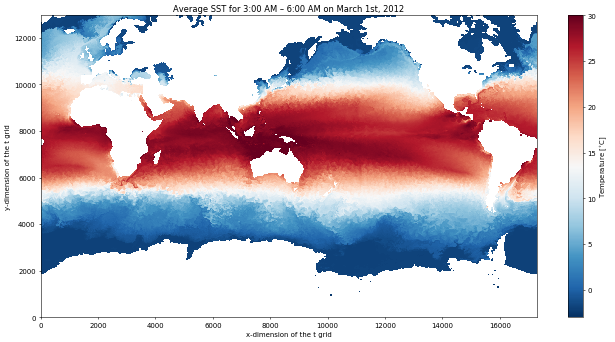

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8), dpi=100)
q = mean_sst.plot()
q.set_clim([-3,30])
q.colorbar.set_label(r"Temperature [$^{\circ}$C]")
plt.title('Average SST for 3:00 AM – 6:00 AM on March 1st, 2012');

#### Step 4: Computing derived quantities

[XGCM](https://xgcm.readthedocs.io/en/latest/) is a python packge for working with the datasets produced by numerical General Circulation Models (GCMs) and similar gridded datasets that are amenable to finite volume analysis. In these datasets, different variables are located at different positions with respect to a volume or area element (e.g. cell center, cell face, etc.) xgcm solves the problem of how to interpolate and difference these variables from one position to another.

In [19]:
import xgcm
grid = xgcm.Grid(coords.drop(['k', 'k_p1']), periodic=['X'])
grid

<xgcm.Grid>
T Axis (not periodic):
  * center   time
X Axis (periodic):
  * center   i --> left
  * left     i_g --> center
Y Axis (not periodic):
  * center   j --> left
  * left     j_g --> center

The relative vorticity $\zeta$ (you can think of this as the "spinny-ness" of a fluid) is given by:
\begin{equation}
\zeta = -\frac{\partial u}{\partial y} + \frac{\partial v}{\partial x} 
\end{equation}
On a discrete grid, this operation is approximated by a first-order finite volume difference:

In [20]:
ζ = (-grid.diff(ds.U * coords.dxC, 'Y', boundary='extend')
        +grid.diff(ds.V * coords.dyC, 'X', boundary='extend'))/coords.rAz
ζ

<xarray.DataArray (time: 9030, j_g: 12960, i_g: 17280)>
dask.array<truediv, shape=(9030, 12960, 17280), dtype=float32, chunksize=(1, 4319, 4319), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279

In [26]:
time_point = '2012-03-01T06'
mean_ζ = ζ.sel(time=time_point).coarsen(i_g=4,j_g=4).mean(dim=['i_g', 'j_g'])

In [28]:
mean_ζ = mean_ζ.compute()

[#######                                 ] | 18% Completed |  5.1s

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed | 23.4s


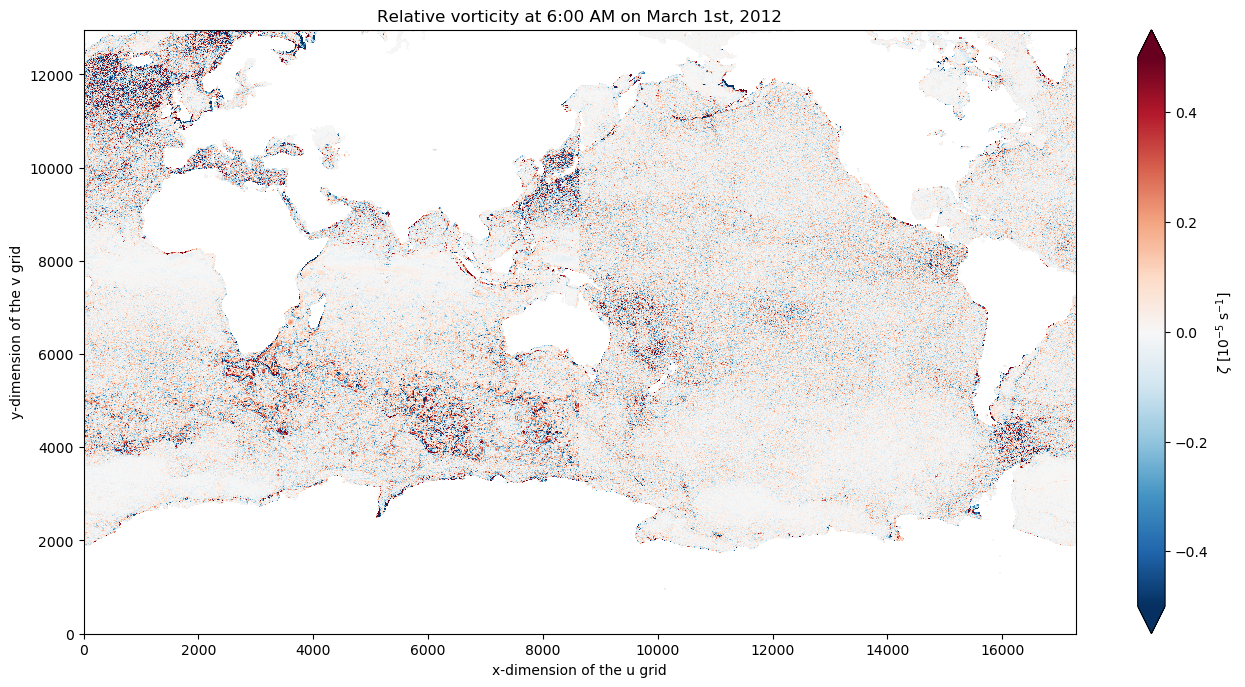

In [31]:
plt.figure(figsize=(16,8), dpi=100)
q = (mean_ζ*1.e4).plot(extend='both')
q.colorbar.set_label(r"$\zeta$ [10$^{-4}$ s$^{-1}$]")
q.set_clim([-0.5,0.5])
plt.title('Relative vorticity at 6:00 AM on March 1st, 2012');

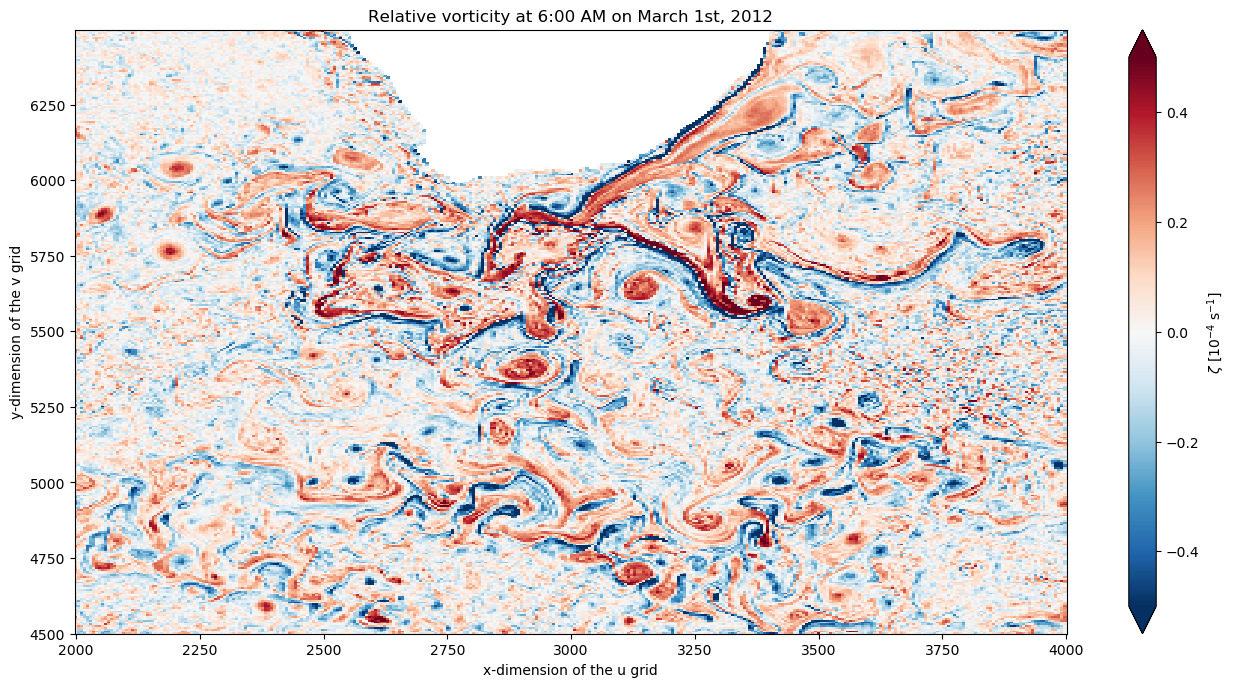

In [32]:
plt.figure(figsize=(16,8), dpi=100)
q = (mean_ζ*1.e4).sel(i_g=slice(2000,4000), j_g=slice(4500,6500)).plot(extend='both')
q.colorbar.set_label(r"$\zeta$ [10$^{-4}$ s$^{-1}$]")
q.set_clim([-0.5,0.5])
plt.title('Relative vorticity at 6:00 AM on March 1st, 2012');

#### Coming Soon: attaching values to our coordinates
The latitude and longitude values corresponding to the `i` and `j` variables are for some reason contained in a separate dataset in the Pangeo catalog that only contained grid coordinates. It is fairly straightforward to merge our SST dataset with the grid coordinates dataset, but I did not have time to implement it for today's tutorial.

In [29]:
grid = cat.ocean.LLC4320.LLC4320_grid.to_dask() # load data set as an xarray.Dataset
grid

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, k_p1: 2, time: 9030)
Coordinates:
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   float32 ...
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Z        float32 ...
    Zl       float32 ...
    Zp1      (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    Zu       float32 ...
    drC      (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    drF      float32 ...
    dxC      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    hFacC    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    hFacS    (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    hFacW    (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    iter     (time) int64 dask.array<chunksize=(9030,), meta=np.ndarray>
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    k        int64 ...
    k_l      int64 ...
  * k_p1     (k_p1) int64 0 1
    k_u      int64 ...
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

#### Exercise: explore one of the data sets below with all the tools you've learned so far

Here is an example of the syntax for reading in a single dataset from the catalog:
```python
ds = cat.[domain_name].[model_name].[variable_subset_name].to_dask()
```
In some cases, only one or two of the keys are needed, as in the following example for a derived satellite product of sea surface height:
```python
ds = cat.ocean.sea_surface_height.to_dask()
```

A list of all of the data sets in the [Pangeo catalog](https://pangeo-data.github.io/pangeo-datastore/) is shown in the following code cell.

Note: alternatively, follow the instructions here for how to access and analyze data sets from the Coupled Model Intercomparison Project Phase 6 (CMIP6).

In [30]:
# Type the code for your excerise here!

list(cat.walk(depth=3).keys())

['ocean.sea_surface_height',
 'ocean.cesm_mom6_example',
 'ocean.ECCOv4r3',
 'ocean.SOSE',
 'ocean.GODAS',
 'ocean.ECCO_layers',
 'ocean.LLC4320.LLC4320_grid',
 'ocean.LLC4320.LLC4320_SST',
 'ocean.LLC4320.LLC4320_SSS',
 'ocean.LLC4320.LLC4320_SSH',
 'ocean.LLC4320.LLC4320_SSU',
 'ocean.LLC4320.LLC4320_SSV',
 'ocean.LLC4320',
 'ocean.GFDL_CM2_6.GFDL_CM2_6_control_ocean',
 'ocean.GFDL_CM2_6.GFDL_CM2_6_control_ocean_surface',
 'ocean.GFDL_CM2_6.GFDL_CM2_6_control_ocean_3D',
 'ocean.GFDL_CM2_6.GFDL_CM2_6_control_ocean_transport',
 'ocean.GFDL_CM2_6.GFDL_CM2_6_control_ocean_boundary_flux',
 'ocean.GFDL_CM2_6.GFDL_CM2_6_one_percent_ocean',
 'ocean.GFDL_CM2_6.GFDL_CM2_6_one_percent_ocean_surface',
 'ocean.GFDL_CM2_6.GFDL_CM2_6_one_percent_ocean_3D',
 'ocean.GFDL_CM2_6.GFDL_CM2_6_one_percent_ocean_transport',
 'ocean.GFDL_CM2_6.GFDL_CM2_6_one_percent_ocean_boundary_flux',
 'ocean.GFDL_CM2_6.GFDL_CM2_6_grid',
 'ocean.GFDL_CM2_6',
 'ocean.CESM_POP.CESM_POP_hires_control',
 'ocean.CESM_POP.CESM_